# Multi Voxel Pattern Analysis


In [84]:
import os.path as op
import numpy as np
import nibabel as nib
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import sklearn

In [2]:
# define directory and filenames
BASE_DIR = './ds001246-download/sub-01/ses-imageryTest01/func/'
BASE_FILENAME = 'sub-01_ses-imageryTest01_task-imagery_run-0'
POSTFIX_DATA = '_bold.nii.gz'
POSTFIX_EVENTS = '_events.tsv'

In [3]:
# define a function that loads the data and corresponding event table
def load_run(run_id):
    """This function loads the data and corresponding event table
    for the given run_id"""
    # get the filenames
    events_filename = BASE_FILENAME + str(run_id) + POSTFIX_EVENTS
    data_filename = BASE_FILENAME + str(run_id) + POSTFIX_DATA
    
    # load events
    events_path = op.join(BASE_DIR, events_filename)
    events_data = pd.read_csv(events_path, sep='\t')
    
    # convert seconds to unit of data index (1 index every 3 seconds)
    # and add them as new columns
    events_data['onset_index'] = (events_data['onset']/3).astype('int')
    events_data['duration_index'] = (events_data['duration']/3).astype('int')
    
    # load data
    data_path = op.join(BASE_DIR, data_filename)
    data = nib.load(data_path).get_fdata()
    
    return data, events_data

# create empty lists to hold the data loaded for each run
# so that we can just retrieve it from memory instead of
# from disk
data_list = []
events_list = []
for run_id in range(1,9):
    data, events_data = load_run(run_id)
    data_list.append(data)
    events_list.append(events_data)

# now I will overwrite the load_run function to use data from
# this list instead of the disk, i am overwriting instead of
# creating new one because I want it to be a replacable function
# to the original
def load_run(run_id):
    # list index start from 0 instead of 1
    index = run_id - 1
    
    # retrieve from memory
    data = data_list[run_id-1]
    events_data = events_list[run_id-1]
    
    return data, events_data

In [5]:
# utility functions
# here I organize the steps that I followed in scratch_analysis notebook
# into functions so the main program is not so cluttered

def search_light(data,i,j,k):
    """This function extracts the multi-voxel data from given 
    3D neuroimage using a searchlight composed of 33 voxels 
    centered at voxel (i,j,k), it assumes that data is 3D"""
    # make an empty mask
    mask = np.zeros(data.shape)
    
    # generate the searchlight mask around i,j,k
    mask[i-2:i+3,j,k] = 1
    mask[i,j-2:j+3,k] = 1
    mask[i,j,k-2:k+3] = 1

    mask[i-1:i+2,j-1:j+2,k-1] = 1
    mask[i-1:i+2,j-1:j+2,k+1] = 1

    mask[i-1:i+2,j-1,k-1:k+2] = 1
    mask[i-1:i+2,j+1,k-1:k+2] = 1

    mask[i-1,j-1:j+2,k-1:k+2] = 1
    mask[i+1,j-1:j+2,k-1:k+2] = 1
    
    mvp = data[mask==1]
    
    return mvp


def mvps_from_search_light(data, i, j, k):
    """This function is based on the search_light function
    and it extracts a time series of mvp"""
    # a list to store all mvps
    mvp_list = []

    for t in range(data.shape[3]):
        # extract the mvp at time t and around i,j,k
        mvp = search_light(data[...,t], i, j, k)

        # reshape the list to a column vector
        mvp = mvp[:,None]

        # append to the list of mvps for all time
        mvp_list.append(mvp)

    # merge the mvp_list into a numpy array by horizontally
    # stacking the columns from each time point
    mvps = np.hstack(mvp_list)
    
    return mvps


def preprocess_mvps(mvps):
    """This function remove the motion and mean signal from MVP
    using simple regression model and convert the residue to 
    z-score"""
    
    # new numpy array to store the z-scored mvps residue
    z_mvps = np.zeros(mvps.shape)

    # loop over each voxel
    for voxel in range(mvps.shape[0]):
        # retrieve the time series for the given voxel
        y = mvps[voxel,:]
        x = np.arange(len(y))

        # run a simple linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # calculate residue
        residue = y - x*slope - intercept

        # convert to z-score
        z_residue = stats.zscore(residue)

        # store it to the new numpy array
        z_mvps[voxel,:] = z_residue
    
    return z_mvps


def generate_condition_labels(events_data):
    """This function generates the condition labels using
    the events table loaded, it accounts for the hemodynamical
    lag by shifting the label forward by two indices
    
    cond_2: evaluation score = 3
    cond_1: evaluation score = 5
    cond_0: everything else    

    loop over rows of the events table and look at 
    the evaluation value to fill the condition label
    the indices to fill is from onset_index to
    onset_index + duration_index - 1 (inclusive)
    """

    # make an emply array to store the condition label
    cond_labels = np.zeros(mvps.shape[1])

    # loop over rows
    for index, row in events_data.iterrows():
        i_start = row['onset_index']
        i_end = row['onset_index'] + row['duration_index']  # exlusive

        # default condition label
        cond = 0

        # find condition label only for imagery event
        if row['event_type'] == 'imagery':
            if row['evaluation'] == 5:
                cond = 1
            elif row['evaluation'] == 3:
                cond = 2

        # assign the condition labels
        cond_labels[i_start:i_end] = cond
        
    # now shift the condition label based on the hemodynamic lag
    # since the lag is usually 5-6 seconds, which correspond to a 
    # shift of about 2 indexes to the right

    # generate an empty array to hold the shifted condition label
    cond_labels_shifted = np.zeros(cond_labels.shape)

    # assign the condition labels to the new array shifted by two indices
    cond_labels_shifted[2:] = cond_labels[:-2]

    return cond_labels_shifted


def calculate_proto_mvps(mvps, labels):
    """This function calculates prototypical mean MVP for 
    the three conditions (1,2,3) using the z-scored mvps and
    shifted labels provided"""
    
    # check if the label exists, if not return 0 by default
    if np.sum(labels == 1) == 0:
        cond_1_proto = 0
    else:
        cond_1_mvps = mvps[:, labels == 1]
        cond_1_proto = np.mean(cond_1_mvps, axis=1)
    
    if np.sum(labels == 2) == 0:
        cond_2_proto = 0
    else:
        cond_2_mvps = mvps[:, labels == 2]
        cond_2_proto = np.mean(cond_2_mvps, axis=1)


    return cond_1_proto, cond_2_proto
    

def calculate_mvp_corrs(mvps, cond_1_proto, cond_2_proto):
    """This function calculates the correlation to each prototypical 
    MVPs for each time point and generate three time series each 
    corresponding to a condition. The input should be z-scored mvps 
    and prototypical MVPs for each condition (1,2,3). The correlation
    is transformed using Fisher's z-transformation at the end"""
    # create an empty numpy array to hold the correlation data
    corrs = np.zeros((2, mvps.shape[1]))

    # calculate the correlation for condition 1
    for t in range(mvps.shape[1]):
        corrs[0,t] = np.corrcoef(cond_1_proto, z_mvps[:,t])[0,1]
        corrs[1,t] = np.corrcoef(cond_2_proto, z_mvps[:,t])[0,1]
        
    # the next step was to convert the correlation
    # value r using fisher z-transformation
    # ref: https://en.wikipedia.org/wiki/Fisher_transformation
    z_corrs = np.arctanh(corrs)
    
    return z_corrs


def calculate_mvp_discriminability(mvp_corrs, labels):
    """This function calculates the MVP discriminability by looking
    at the MVP correlation time series of different conditions"""
    
    # first narrow down to condition 1, 2, 3 only (ignoring cond 0)
    coors_subset = mvp_corrs[:,labels!= 0]
    labels_subset = labels[labels != 0]

    # generate an empty numpy array to store MVPA discriminability
    mvpa_disc = np.zeros(len(labels_subset))

    # loop over each time point
    for t in range(len(labels_subset)):
        # get correct label
        correct_lbl = int(labels_subset[t])

        # get incorrect labels by removing the correct labels
        # from all labels
        lbls = [1, 2]    
        lbls.remove(correct_lbl)
        incorrect_lbls = np.array(lbls)  # np.array is easier to work with

        # correlation with correct label
        r_correct = coors_subset[correct_lbl-1, t]

        #correlation with incorrect labels
        r_incorrect = coors_subset[incorrect_lbls-1, t]

        # mvpa discriminability is r_correct - max(r_incorrect)
        mvpa_disc[t] = r_correct - max(r_incorrect)
        
    return mvpa_disc

In [100]:
# define seed region
i,j,k = 30,55,30

# define test set
test = 1
train = [2,3,4,5,6,7,8]

# empty arrays to store the prototypical mvp for each condition
cond_1_proto = np.zeros(33)
cond_2_proto = np.zeros(33)
cond_3_proto = np.zeros(33)

# go through the training set to calculate protypical
# MVP for each condition
all_data = []
all_labels = []

for run_id in train:
    # load data
    data, events_data = load_run(run_id)
    
    # extract the mvp pattern corresponding to the seed region
    mvps = mvps_from_search_light(data, i, j, k)
    
    # preprocess mvps
    z_mvps = preprocess_mvps(mvps)
    
    # generate labels
    labels = generate_condition_labels(events_data)
    
    data = z_mvps[:,labels!=0]
    labels = labels[labels!=0]
    
    all_data.append(data)
    all_labels.append(labels)

data_train = np.hstack(all_data).T  # transpose is so that it is compatible with sklearn
labels_train = np.hstack(all_labels)

# load test data
data, events_data = load_run(test)
# extract the mvp pattern corresponding to the seed region
mvps = mvps_from_search_light(data, i, j, k)

# preprocess mvps
z_mvps = preprocess_mvps(mvps)

# generate labels
labels = generate_condition_labels(events_data)

# create test data set
data_test = z_mvps[:,labels!=0].T
labels_test = labels[labels!=0]


In [101]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', [1,2], labels_train)

In [102]:
weights = np.zeros(len(labels_train))
weights[labels_train == 1] = class_weights[0]
weights[labels_train == 2] = class_weights[1]

In [103]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=5)

model.fit(data_train, labels_train, sample_weight=weights)
model.score(data_test, labels_test)

0.57

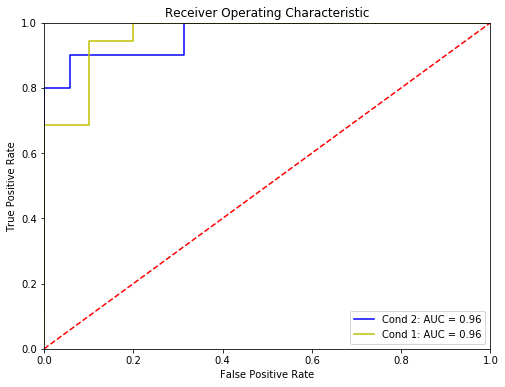

In [61]:
from sklearn import metrics 

plt.figure(figsize=(8,6))
probs = model.predict_proba(data_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(labels_test, preds, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Cond 2: AUC = %0.2f' % roc_auc)

preds = probs[:, 0]
fpr, tpr, threshold = metrics.roc_curve(labels_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'y', label = 'Cond 1: AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

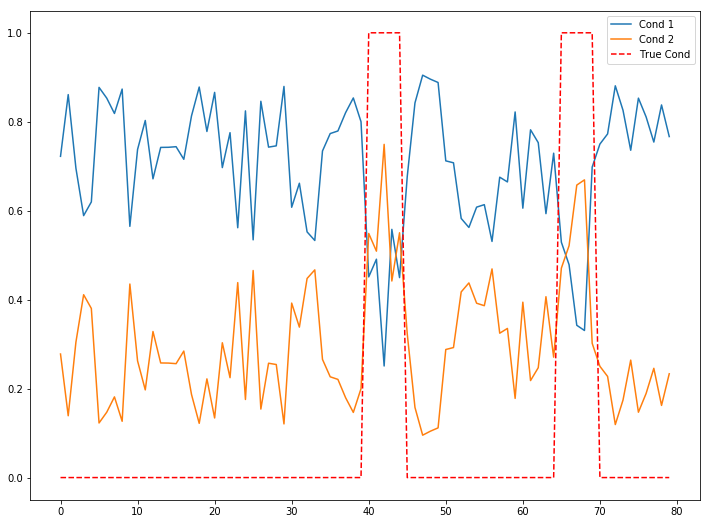

In [67]:
plt.figure(figsize=(12,9))
plt.plot(probs[:,0], label='Cond 1')
plt.plot(probs[:,1], label='Cond 2')
plt.plot(labels_test - 1, 'r--', label='True Cond')
plt.legend()
plt.show()

In [104]:
# repeat it to all folds with the cross-validation approach


# define a new function that summarize the previous study
def MVPA_CV(model, train, test, i, j, k):
    """This functions combine the cross validation study
    implemented in the last cell. 
    
    Params:
        test: int
        train: list of int
        i,j,k: index of the center of searchlight
        
    Returns:
        mvp_disc: MVP discriminability
        mvp_corrs: MVP correlation time series
    """
    
    # go through the training set to calculate protypical
    # MVP for each condition
    all_data = []
    all_labels = []

    for run_id in train:
        # load data
        data, events_data = load_run(run_id)

        # extract the mvp pattern corresponding to the seed region
        mvps = mvps_from_search_light(data, i, j, k)

        # preprocess mvps
        z_mvps = preprocess_mvps(mvps)

        # generate labels
        labels = generate_condition_labels(events_data)

        data = z_mvps[:,labels!=0]
        labels = labels[labels!=0]

        all_data.append(data)
        all_labels.append(labels)

    data_train = np.hstack(all_data).T  # transpose is so that it is compatible with sklearn
    labels_train = np.hstack(all_labels)

    # load test data
    run_id = test
    data, events_data = load_run(run_id)
    
    # extract the mvp pattern corresponding to the seed region
    mvps = mvps_from_search_light(data, i, j, k)

    # preprocess mvps
    z_mvps = preprocess_mvps(mvps)

    # generate labels
    labels = generate_condition_labels(events_data)

    # create test data set
    data_test = z_mvps[:,labels!=0].T
    labels_test = labels[labels!=0]

    # balance the two classes before training
    # compute the class weights needed
    class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', [1,2], labels_train)
    
    # compute the sample weights
    weights = np.zeros(len(labels_train))
    weights[labels_train == 1] = class_weights[0]
    weights[labels_train == 2] = class_weights[1]
    
    model.fit(data_train, labels_train, sample_weight=weights)
    probs = model.predict_proba(data_test)
    score = model.score(data_test, labels_test)

    return probs, labels_test, score

In [105]:
# define seed region
i,j,k = 30,55,30

# generate an empty array to hold the mvp discriminability values for all folds
overall_mvp_disc = np.array([])
scores = []

for run_id in range(1,9):
    # set test run id
    test = run_id

    # set train run ids
    all_runs = np.arange(1,9)

    # remove the test from train to comply to all but one analysis
    train = all_runs[all_runs != test]
    
    # define a model
    model = RandomForestClassifier()
    
    # apply cross-validation to get mvp_discriminability
    probs, labels, score = MVPA_CV(model, train, test, i, j, k)
    
    # store score
    scores.append(score)
    
print("Scores:", scores)
print("Mean scores", np.mean(scores))

Scores: [0.86, 0.8133333333333334, 0.525, 0.275, 0.55, 0.55, 0.5875, 0.7625]
Mean scores 0.6154166666666667


In [106]:
def MVPA_CV_searchlight(i,j,k):
    """This function summarizes my earlier calculation that
    calculates the mvp disc for a search light"""
    # generate an empty array to hold the mvp discriminability values for all folds
    overall_mvp_disc = np.array([])
    scores = []

    for run_id in range(1,9):
        # set test run id
        test = run_id

        # set train run ids
        all_runs = np.arange(1,9)

        # remove the test from train to comply to all but one analysis
        train = all_runs[all_runs != test]

        # define a model
        model = RandomForestClassifier()

        # apply cross-validation to get mvp_discriminability
        probs, labels, score = MVPA_CV(model, train, test, i, j, k)

        # store score
        scores.append(score)

    print("Scores:", scores)
    print("Mean score:", np.mean(scores))

In [107]:
# generate an empty dictionary to store the mvp discriminability
mvp_disc_list = []

for i in range(20,45,5):
    for j in range(20,45,5):
        for k in range(20,45,5):
            print('************************************************************')
            print('Searchlight at (i,j,k) = (%d, %d, %d)' % (i, j, k))
            MVPA_CV_searchlight(i,j,k)

************************************************************
Searchlight at (i,j,k) = (20, 20, 20)
Scores: [0.86, 0.8, 0.55, 0.225, 0.475, 0.5833333333333334, 0.4875, 0.8125]
Mean score: 0.5991666666666666
************************************************************
Searchlight at (i,j,k) = (20, 20, 25)
Scores: [0.87, 0.8, 0.525, 0.325, 0.525, 0.6166666666666667, 0.525, 0.7125]
Mean score: 0.6123958333333333
************************************************************
Searchlight at (i,j,k) = (20, 20, 30)
Scores: [0.88, 0.8533333333333334, 0.5, 0.3, 0.575, 0.6166666666666667, 0.5875, 0.75]
Mean score: 0.6328125
************************************************************
Searchlight at (i,j,k) = (20, 20, 35)
Scores: [0.9, 0.88, 0.475, 0.25, 0.625, 0.5333333333333333, 0.65, 0.6625]
Mean score: 0.6219791666666666
************************************************************
Searchlight at (i,j,k) = (20, 20, 40)
Scores: [0.92, 0.8266666666666667, 0.5, 0.25, 0.475, 0.6166666666666667, 0.537

Scores: [0.76, 0.84, 0.5, 0.325, 0.525, 0.55, 0.5125, 0.8]
Mean score: 0.6015625
************************************************************
Searchlight at (i,j,k) = (25, 35, 25)
Scores: [0.82, 0.8533333333333334, 0.525, 0.3, 0.525, 0.5333333333333333, 0.5375, 0.825]
Mean score: 0.6148958333333333
************************************************************
Searchlight at (i,j,k) = (25, 35, 30)
Scores: [0.88, 0.8533333333333334, 0.475, 0.275, 0.5, 0.5333333333333333, 0.6, 0.7625]
Mean score: 0.6098958333333333
************************************************************
Searchlight at (i,j,k) = (25, 35, 35)
Scores: [0.87, 0.8666666666666667, 0.525, 0.25, 0.5, 0.55, 0.5125, 0.825]
Mean score: 0.6123958333333334
************************************************************
Searchlight at (i,j,k) = (25, 35, 40)
Scores: [0.87, 0.8133333333333334, 0.45, 0.25, 0.525, 0.5666666666666667, 0.575, 0.7125]
Mean score: 0.5953125
************************************************************
Searchli

Scores: [0.86, 0.8, 0.525, 0.25, 0.5, 0.55, 0.5, 0.75]
Mean score: 0.5918749999999999
************************************************************
Searchlight at (i,j,k) = (35, 25, 25)
Scores: [0.87, 0.8666666666666667, 0.525, 0.275, 0.5, 0.6, 0.5625, 0.7]
Mean score: 0.6123958333333334
************************************************************
Searchlight at (i,j,k) = (35, 25, 30)
Scores: [0.84, 0.8666666666666667, 0.5, 0.3, 0.55, 0.5833333333333334, 0.575, 0.7375]
Mean score: 0.6190625000000001
************************************************************
Searchlight at (i,j,k) = (35, 25, 35)
Scores: [0.86, 0.9066666666666666, 0.5, 0.3, 0.6, 0.5666666666666667, 0.5375, 0.7875]
Mean score: 0.6322916666666666
************************************************************
Searchlight at (i,j,k) = (35, 25, 40)
Scores: [0.84, 0.84, 0.5, 0.25, 0.525, 0.5666666666666667, 0.5125, 0.725]
Mean score: 0.5948958333333333
************************************************************
Searchlight at 

Scores: [0.87, 0.9066666666666666, 0.525, 0.25, 0.475, 0.5833333333333334, 0.4875, 0.7875]
Mean score: 0.610625
************************************************************
Searchlight at (i,j,k) = (40, 40, 30)
Scores: [0.72, 0.8666666666666667, 0.525, 0.275, 0.525, 0.6, 0.575, 0.7875]
Mean score: 0.6092708333333333
************************************************************
Searchlight at (i,j,k) = (40, 40, 35)
Scores: [0.76, 0.8533333333333334, 0.475, 0.25, 0.5, 0.5333333333333333, 0.525, 0.7875]
Mean score: 0.5855208333333333
************************************************************
Searchlight at (i,j,k) = (40, 40, 40)
Scores: [0.87, 0.88, 0.525, 0.275, 0.475, 0.5833333333333334, 0.525, 0.7625]
Mean score: 0.6119791666666666


In [109]:
from sklearn.naive_bayes import GaussianNB

def MVPA_CV_searchlight(i,j,k):
    """This function summarizes my earlier calculation that
    calculates the mvp disc for a search light"""
    # generate an empty array to hold the mvp discriminability values for all folds
    overall_mvp_disc = np.array([])
    scores = []

    for run_id in range(1,9):
        # set test run id
        test = run_id

        # set train run ids
        all_runs = np.arange(1,9)

        # remove the test from train to comply to all but one analysis
        train = all_runs[all_runs != test]

        # define a model
        model = GaussianNB()

        # apply cross-validation to get mvp_discriminability
        probs, labels, score = MVPA_CV(model, train, test, i, j, k)

        # store score
        scores.append(score)

    print("Scores:", scores)
    print("Mean score:", np.mean(scores))

In [110]:
# generate an empty dictionary to store the mvp discriminability
mvp_disc_list = []

for i in range(20,45,5):
    for j in range(20,45,5):
        for k in range(20,45,5):
            print('************************************************************')
            print('Searchlight at (i,j,k) = (%d, %d, %d)' % (i, j, k))
            MVPA_CV_searchlight(i,j,k)

************************************************************
Searchlight at (i,j,k) = (20, 20, 20)
Scores: [0.46, 0.4666666666666667, 0.375, 0.675, 0.525, 0.48333333333333334, 0.425, 0.4875]
Mean score: 0.4871875
************************************************************
Searchlight at (i,j,k) = (20, 20, 25)
Scores: [0.44, 0.29333333333333333, 0.475, 0.5, 0.6, 0.5166666666666667, 0.45, 0.5625]
Mean score: 0.4796875
************************************************************
Searchlight at (i,j,k) = (20, 20, 30)
Scores: [0.34, 0.48, 0.475, 0.6, 0.65, 0.4166666666666667, 0.4, 0.6125]
Mean score: 0.49677083333333333
************************************************************
Searchlight at (i,j,k) = (20, 20, 35)
Scores: [0.39, 0.4, 0.525, 0.55, 0.6, 0.55, 0.425, 0.5375]
Mean score: 0.4971875
************************************************************
Searchlight at (i,j,k) = (20, 20, 40)
Scores: [0.38, 0.3466666666666667, 0.4, 0.525, 0.675, 0.5166666666666667, 0.45, 0.5]
Mean score: 

Scores: [0.41, 0.48, 0.525, 0.5, 0.775, 0.4, 0.375, 0.525]
Mean score: 0.49875
************************************************************
Searchlight at (i,j,k) = (25, 35, 25)
Scores: [0.42, 0.5066666666666667, 0.425, 0.425, 0.45, 0.2833333333333333, 0.1875, 0.475]
Mean score: 0.39656250000000004
************************************************************
Searchlight at (i,j,k) = (25, 35, 30)
Scores: [0.35, 0.6133333333333333, 0.45, 0.575, 0.75, 0.55, 0.3625, 0.45]
Mean score: 0.5126041666666666
************************************************************
Searchlight at (i,j,k) = (25, 35, 35)
Scores: [0.59, 0.6266666666666667, 0.475, 0.55, 0.6, 0.43333333333333335, 0.3875, 0.6125]
Mean score: 0.534375
************************************************************
Searchlight at (i,j,k) = (25, 35, 40)
Scores: [0.42, 0.44, 0.425, 0.55, 0.525, 0.5666666666666667, 0.4375, 0.675]
Mean score: 0.5048958333333333
************************************************************
Searchlight at (i,j

Scores: [0.35, 0.4, 0.55, 0.375, 0.575, 0.5, 0.45, 0.5]
Mean score: 0.4625
************************************************************
Searchlight at (i,j,k) = (35, 25, 25)
Scores: [0.41, 0.4266666666666667, 0.475, 0.65, 0.5, 0.5166666666666667, 0.425, 0.4625]
Mean score: 0.48322916666666665
************************************************************
Searchlight at (i,j,k) = (35, 25, 30)
Scores: [0.47, 0.5066666666666667, 0.475, 0.575, 0.575, 0.6, 0.4875, 0.4875]
Mean score: 0.5220833333333332
************************************************************
Searchlight at (i,j,k) = (35, 25, 35)
Scores: [0.39, 0.4666666666666667, 0.425, 0.5, 0.65, 0.5333333333333333, 0.4125, 0.525]
Mean score: 0.48781250000000004
************************************************************
Searchlight at (i,j,k) = (35, 25, 40)
Scores: [0.47, 0.5066666666666667, 0.475, 0.6, 0.6, 0.55, 0.5125, 0.625]
Mean score: 0.5423958333333333
************************************************************
Searchlight at (

Scores: [0.29, 0.5466666666666666, 0.575, 0.575, 0.675, 0.43333333333333335, 0.425, 0.45]
Mean score: 0.49624999999999997
************************************************************
Searchlight at (i,j,k) = (40, 40, 25)
Scores: [0.27, 0.56, 0.625, 0.475, 0.65, 0.45, 0.4375, 0.45]
Mean score: 0.48968750000000005
************************************************************
Searchlight at (i,j,k) = (40, 40, 30)
Scores: [0.36, 0.44, 0.7, 0.5, 0.55, 0.45, 0.4, 0.55]
Mean score: 0.49375
************************************************************
Searchlight at (i,j,k) = (40, 40, 35)
Scores: [0.36, 0.4533333333333333, 0.7, 0.475, 0.575, 0.45, 0.4875, 0.65]
Mean score: 0.5188541666666666
************************************************************
Searchlight at (i,j,k) = (40, 40, 40)
Scores: [0.24, 0.4533333333333333, 0.55, 0.475, 0.325, 0.6333333333333333, 0.4625, 0.6375]
Mean score: 0.47208333333333335
